# **Urban Nightscapes: An analysis of San Antonio, Texas using ISS photographs**

In [188]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import numpy as np
import numpy.ma as ma
import numpy.random
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from pprint import pprint as pp

## **Original Astronaut Photographs: nighttime RGB color composites**
[Gateway to Astronaut Photography](https://eol.jsc.nasa.gov)

/home/nate/anaconda3/envs/bradj_nightscapes/lib/python3.9/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


<AxesSubplot:title={'center':'ISS045-E-155795'}>

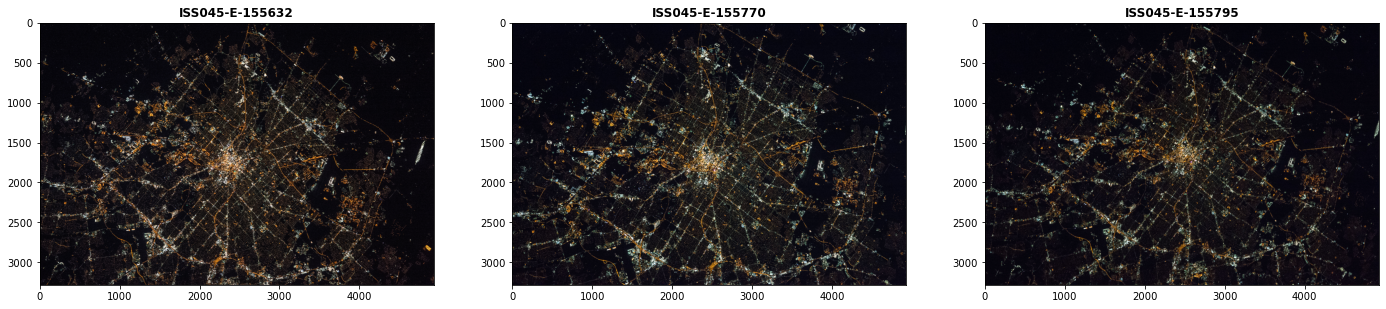

In [176]:
# RGB image filenames
original_632 = "data/original/ISS045-E-163632.jpeg"
original_770 = "data/original/ISS045-E-155770.jpeg"
original_795 = "data/original/ISS045-E-155795.jpeg"

# Intensity image filenames
intensity_632 = "data/intensity/ntl632.img"
intensity_770 = "data/intensity/ntl770.img"
intensity_795 = "data/intensity/ntl795.img"

# Impervious Cover image filename
impervious_data = "data/impervious.tif"

# GLCM Texture image filenames
texture_632 = "data/texture/tex632-5_2-2_7x7mean.img"
texture_770 = "data/texture/tex770-5_2-2_7x7mean.img"
texture_795 = "data/texture/tex795-5_2-2_7x7mean.img"

# DatasetReader objects
o632_dsr = rasterio.open(original_632)
o770_dsr = rasterio.open(original_770)
o795_dsr = rasterio.open(original_795)
# ---
i632_dsr = rasterio.open(intensity_632)
i770_dsr = rasterio.open(intensity_770)
i795_dsr = rasterio.open(intensity_795)
impervious_dsr = rasterio.open(impervious_data)
t632_dsr = rasterio.open(texture_632)
t770_dsr = rasterio.open(texture_770)
t795_dsr = rasterio.open(texture_795)

fig, ax = plt.subplots(1,3, figsize=(24,12))
show(o632_dsr, title="ISS045-E-155632", ax=ax[0])
show(o770_dsr, title="ISS045-E-155770", ax=ax[1])
show(o795_dsr, title="ISS045-E-155795", ax=ax[2])

## **Light Intensity Images...and Impervious Cover**

These light intensity images are the average of the RGB bands. Impervious cover is from the National Land Cover Database (NLCD).

(0.0, 1.0, 0.0, 1.0)

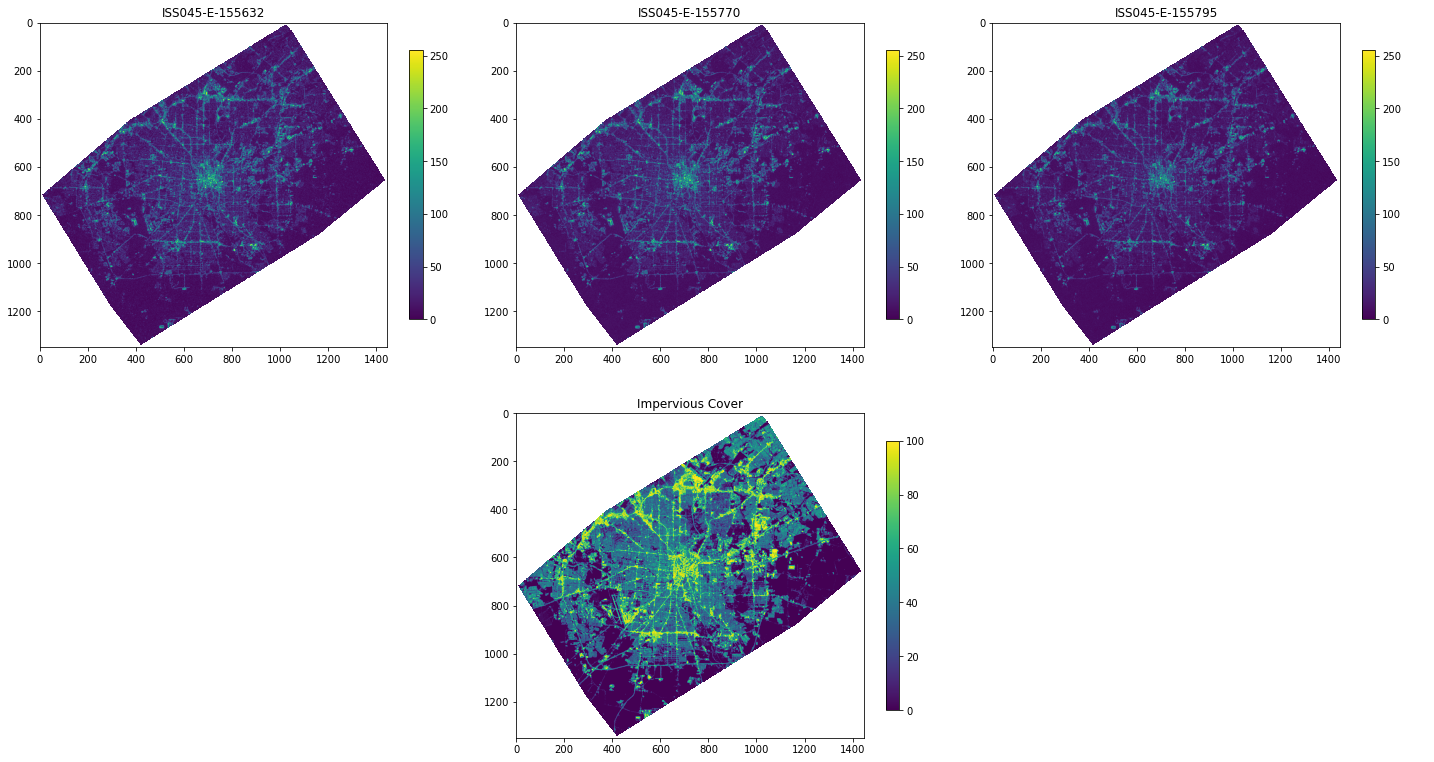

In [177]:
# ndarray objects
i632 = np.ma.masked_where(i632_dsr.read(1) > 255, i632_dsr.read(1))
i770 = np.ma.masked_where(i770_dsr.read(1) > 255, i770_dsr.read(1))
i795 = np.ma.masked_where(i795_dsr.read(1) > 255, i795_dsr.read(1))
impervious = np.ma.masked_where(impervious_dsr.read(1) > 100, impervious_dsr.read(1))

# Plotting
fig, ax = plt.subplots(2,3, figsize=(20,11))
fig.tight_layout()

# a
a = ax[0, 0].imshow(i632)
fig.colorbar(a, ax=ax[0, 0], shrink=0.75)
ax[0, 0].set_title("ISS045-E-155632", fontsize= 12)

# b
b = ax[0, 1].imshow(i770)
fig.colorbar(b, ax=ax[0, 1], shrink=0.75)
ax[0, 1].set_title("ISS045-E-155770", fontsize= 12)

# c
b = ax[0, 2].imshow(i795)
fig.colorbar(b, ax=ax[0, 2], shrink=0.75)
ax[0, 2].set_title("ISS045-E-155795", fontsize= 12)

# d
b = ax[1, 1].imshow(impervious)
fig.colorbar(b, ax=ax[1, 1], shrink=0.75)
ax[1, 1].set_title("Impervious Cover", fontsize= 12)

ax[1][0].axis('off')
ax[1][2].axis('off')

## **Texture Images**

Text(0.5, 0.98, 'Unscaled GLCM Texture Images')

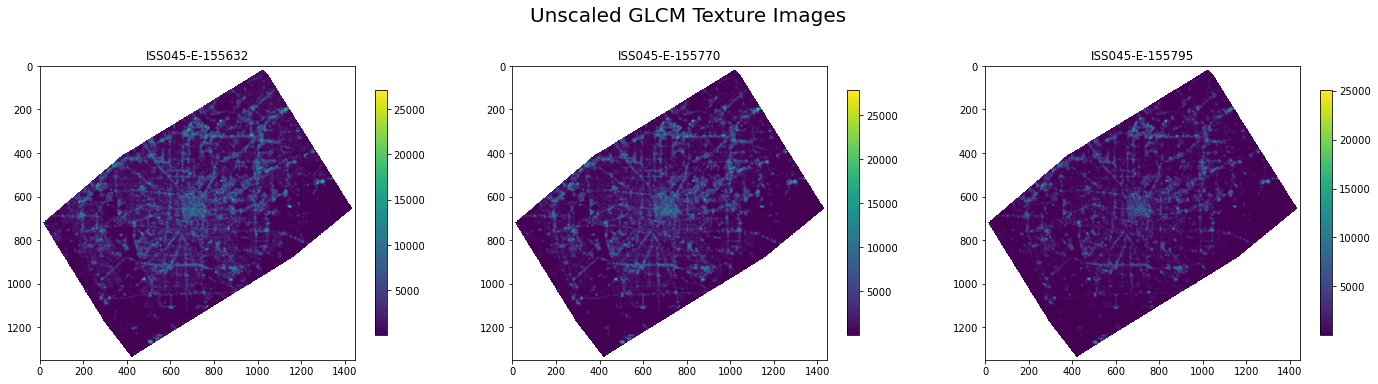

In [184]:
t632 = np.ma.masked_invalid(t632_dsr.read(1))
t770 = np.ma.masked_invalid(t770_dsr.read(1))
t795 = np.ma.masked_invalid(t795_dsr.read(1))

fig_unscaled, ax = plt.subplots(1,3, figsize=(24,6))

# a
a = ax[0].imshow(t632)
fig_unscaled.colorbar(a, ax=ax[0], shrink=0.75)
ax[0].set_title("ISS045-E-155632", fontsize= 12)

# b
b = ax[1].imshow(t770)
fig_unscaled.colorbar(b, ax=ax[1], shrink=0.75)
ax[1].set_title("ISS045-E-155770", fontsize= 12)

# c
b = ax[2].imshow(t795)
fig_unscaled.colorbar(b, ax=ax[2], shrink=0.75)
ax[2].set_title("ISS045-E-155795", fontsize= 12)

fig_unscaled.suptitle("Unscaled GLCM Texture Images", fontsize=20)

#### Unscaled GLCM Texture Histograms

The minimum/maximum values for t632 are: 35.4648551940918 and 27056.361328125
The minimum/maximum values for t770 are: 16.396825790405273 and 27823.41796875
The minimum/maximum values for t795 are: 14.337868690490723 and 25021.107421875


<Figure size 432x288 with 0 Axes>

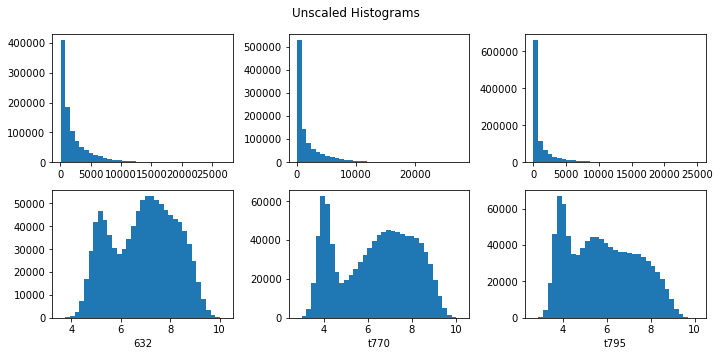

In [185]:
bins = 35
plt.clf()
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(10, 5))

# We can set the number of bins with the `bins` kwarg
axs[0, 0].hist(t632.flatten().astype('float32'), bins=bins)
axs[0, 1].hist(t770.flatten().astype('float32'), bins=bins)
axs[0, 2].hist(t795.flatten().astype('float32'), bins=bins)

axs[1, 0].hist(np.log(t632.flatten().astype('float32')), bins=bins)
axs[1, 0].set_xlabel("632")
axs[1, 1].hist(np.log(t770.flatten().astype('float32')), bins=bins)
axs[1, 1].set_xlabel("t770")
axs[1, 2].hist(np.log(t795.flatten().astype('float32')), bins=bins)
axs[1, 2].set_xlabel("t795")

fig.suptitle("Unscaled Histograms")

print(f"The minimum/maximum values for t632 are: {t632.min()} and {t632.max()}")
print(f"The minimum/maximum values for t770 are: {t770.min()} and {t770.max()}")
print(f"The minimum/maximum values for t795 are: {t795.min()} and {t795.max()}")

#### Scale GLCM Texture Images

In [194]:
## Manual min-max scaling
# min632, max632 = t632.min(), t632.max() # t632.min(), t632.max() or alternate values GT min or LT max
# min770, max770 = t770.min(), t770.max() # t770.min(), t770.max() or alternate values GT min or LT max
# min795, max795 = t795.min(), t795.max() # t795.min(), t795.max() or alternate values GT min or LT max
# range632, range770, range795 = max632 - min632, max770 - min770, max795 - min795
# ---
# t632[t632 < min632] = min632
# t632[t632 > max632] = max632
# t770[t770 < min770] = min770
# t770[t770 > max770] = max770
# t795[t795 < min795] = min795
# t795[t795 > max795] = max795
# ---
# t632 = (t632 - min632) / max632
# t770 = (t770 - min770) / max770
# t795 = (t795 - min795) / max795

# ### sklearn scaling: PowerTransformer
# pt632, pt770, pt795 = PowerTransformer(), PowerTransformer(), PowerTransformer()
# t632 = pt632.fit_transform(t632)
# t770 = pt770.fit_transform(t770)
# t795 = pt795.fit_transform(t795)

### sklearn scaling: QuantileTransformer
qt632, qt770, qt795 = QuantileTransformer(output_distribution='normal'), QuantileTransformer(output_distribution='normal'), QuantileTransformer(output_distribution='normal')
qt632.fit(np.ma.compressed(t632))
qt770.fit(np.ma.compressed(t770))
qt795.fit(np.ma.compressed(t795))
# ---
t632 = qt632.transform(t632)
t770 = qt770.transform(t770)
t795 = qt795.transform(t795)

fig_unscaled, ax = plt.subplots(1,3, figsize=(24,6))

# a
a = ax[0].imshow(t632)
fig_unscaled.colorbar(a, ax=ax[0], shrink=0.75)
ax[0].set_title("ISS045-E-155632", fontsize= 12)

# b
b = ax[1].imshow(t770)
fig_unscaled.colorbar(b, ax=ax[1], shrink=0.75)
ax[1].set_title("ISS045-E-155770", fontsize= 12)

# c
b = ax[2].imshow(t795)
fig_unscaled.colorbar(b, ax=ax[2], shrink=0.75)
ax[2].set_title("ISS045-E-155795", fontsize= 12)

fig_unscaled.suptitle("Scaled GLCM Texture Images", fontsize=20)

ValueError: Expected 2D array, got 1D array instead:
array=[nan nan nan ... nan nan nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

The minimum/maximum values for t632 are: nan and nan
The minimum/maximum values for t770 are: nan and nan
The minimum/maximum values for t795 are: nan and nan


<Figure size 432x288 with 0 Axes>

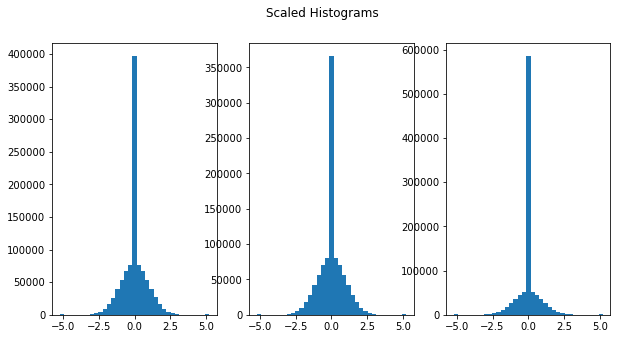

In [193]:
bins = 35
plt.clf()
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=False, figsize=(10, 5))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(t632.flatten().astype('float32'), bins=bins)
axs[1].hist(t770.flatten().astype('float32'), bins=bins)
axs[2].hist(t795.flatten().astype('float32'), bins=bins)

## This is only done for taking log of manually rescaled histograms...also add 2nd axis to above
# axs[1, 0].hist(np.log(t632.flatten().astype('float32')), bins=bins)
# axs[1, 0].set_xlabel("632")
# axs[1, 1].hist(np.log(t770.flatten().astype('float32')), bins=bins)
# axs[1, 1].set_xlabel("t770")
# axs[1, 2].hist(np.log(t795.flatten().astype('float32')), bins=bins)
# axs[1, 2].set_xlabel("t795")

fig.suptitle("Scaled Histograms")

print(f"The minimum/maximum values for t632 are: {t632.min()} and {t632.max()}")
print(f"The minimum/maximum values for t770 are: {t770.min()} and {t770.max()}")
print(f"The minimum/maximum values for t795 are: {t795.min()} and {t795.max()}")

i632: 0/255 <--> x632: 0.0/251.38257890939713
i770: 0/255 <--> x770: 0.0/252.21253037452698
i795: 0/255 <--> x795: 0.0/251.95320188999176


Text(0.5, 0.98, 'Scaled, GLCM-adjusted Nighttime Lights Images')

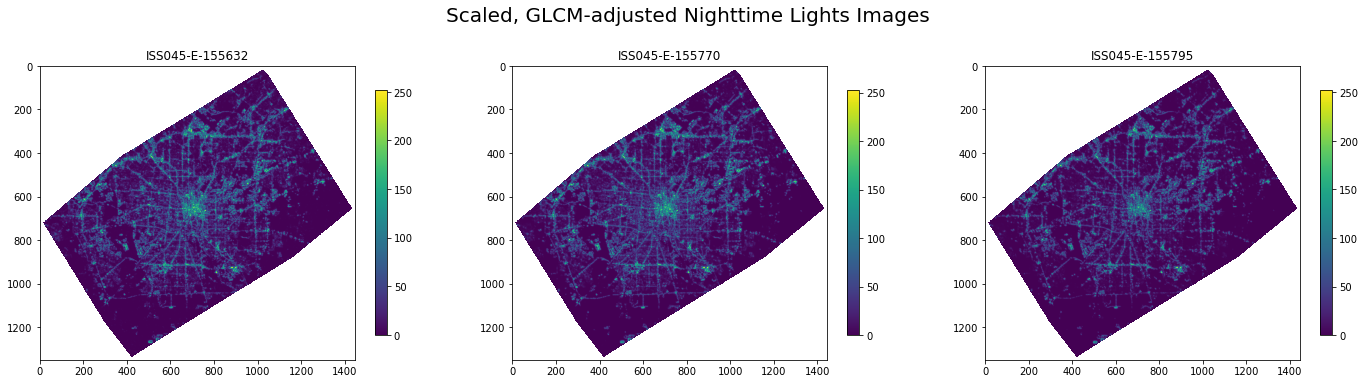

In [159]:
x632 = t632 * i632
x770 = t770 * i770
x795 = t795 * i795

print(f"i632: {i632.min()}/{i632.max()} <--> x632: {x632.min()}/{x632.max()}")
print(f"i770: {i770.min()}/{i770.max()} <--> x770: {x770.min()}/{x770.max()}")
print(f"i795: {i795.min()}/{i795.max()} <--> x795: {x795.min()}/{x795.max()}")

fig_unscaled, ax = plt.subplots(1,3, figsize=(24,6))

# a
a = ax[0].imshow(x632)
fig_unscaled.colorbar(a, ax=ax[0], shrink=0.75)
ax[0].set_title("ISS045-E-155632", fontsize= 12)

# b
b = ax[1].imshow(x770)
fig_unscaled.colorbar(b, ax=ax[1], shrink=0.75)
ax[1].set_title("ISS045-E-155770", fontsize= 12)

# c
b = ax[2].imshow(x795)
fig_unscaled.colorbar(b, ax=ax[2], shrink=0.75)
ax[2].set_title("ISS045-E-155795", fontsize= 12)

fig_unscaled.suptitle("Scaled, GLCM-adjusted Nighttime Lights Images", fontsize=20)

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
(1350, 1447)
(1350, 1447)
t min: 35.4648551940918, t max: 27056.361328125
i min: 0, i max: 255


<AxesSubplot:title={'center':'ISS045-E-155795'}>

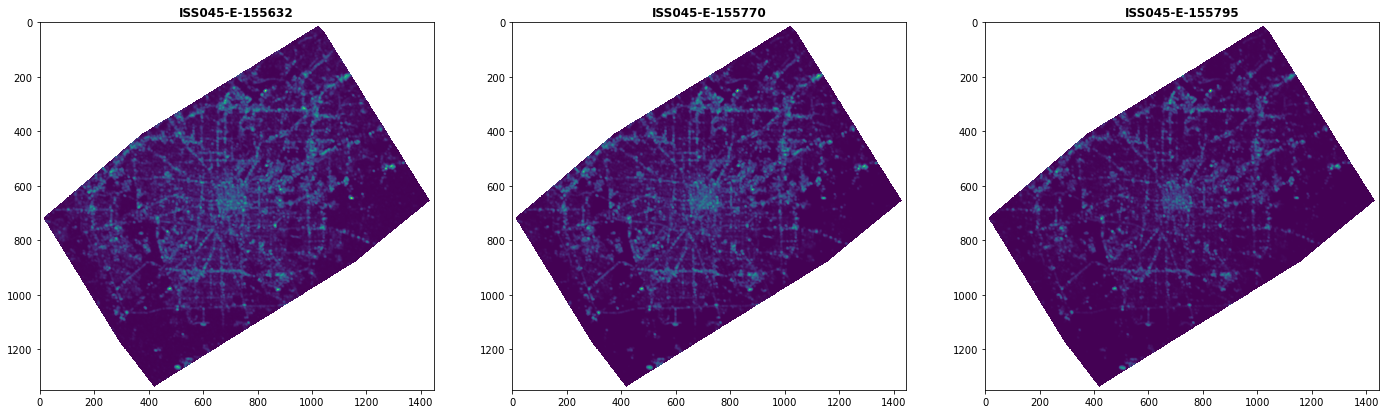

In [79]:
t = np.ma.masked_invalid(t632.read(1))
i = np.ma.masked_where(i632.read(1) > 255, i632.read(1))

print(type(t))
print(type(i))
print(t.shape)
print(i.shape)
print(f"t min: {t.min()}, t max: {t.max()}")
print(f"i min: {i.min()}, i max: {i.max()}")

fig, ax = plt.subplots(1,3, figsize=(24,10))

# # a
# a = ax[0].imshow(t632.read(1))
# fig.colorbar(a, ax=ax[0], shrink=0.5)
# ax[0].set_title("ISS045-E-155632", fontsize= 12)

# # b
# b = ax[1].imshow(t770.read(1))
# fig.colorbar(b, ax=ax[1], shrink=0.5)
# ax[1].set_title("ISS045-E-155770", fontsize= 12)

# # c
# b = ax[2].imshow(t795.read(1))
# fig.colorbar(b, ax=ax[2], shrink=0.5)
# ax[2].set_title("ISS045-E-155795", fontsize= 12)

## **Selected Image Analysis**
### Print some metadata for selected data

In [34]:
selected_image = 632 # 632 or 770 or 795

ntl = globals()[f"i{selected_image}"]
tex = globals()[f"t{selected_image}"]

print(f"The number of bands in {impervious.name} is {impervious.count}.")
print(f"The width (or number of columns) of the image is: {impervious.width}.")
print(f"The height (or number of rows) the image is {impervious.height}.")
print(f"The datatype is {impervious.dtypes}")
print(impervious.bounds)
print(f"The upper-left coordinate is {impervious.transform * (0, 0)}.")
print(f"\tThe min and max values are: {np.min(impervious.read(1))} and {np.max(impervious.read(1))}  *ArcGIS codes 'null' values as large positive numbers??")

print()

print(f"The number of bands in {ntl.name} is {ntl.count}.")
print(f"The width (or number of columns) of the image is: {ntl.width}.")
print(f"The height (or number of rows) the image is {ntl.height}.")
print(f"The datatype is {ntl.dtypes}")
print(ntl.bounds)
print(f"The upper-left coordinate is {ntl.transform * (0, 0)}.")
print(f"\tThe min and max values are: {np.min(ntl.read(1))} and {np.max(ntl.read(1))} *ERDAS codes 'null' values as large negative numbers??")

print()

print(f"The number of bands in {tex.name} is {tex.count}.")
print(f"The width (or number of columns) of the image is: {tex.width}.")
print(f"The height (or number of rows) the image is {tex.height}.")
print(f"The datatype is {tex.dtypes}")
print(tex.bounds)
print(f"The upper-left coordinate is {tex.transform * (0, 0)}.")
print(f"\tThe min and max values are: {np.min(tex.read(1))} and {np.max(tex.read(1))} *ERDAS codes 'null' values as large negative numbers??")

The number of bands in data/impervious.tif is 1.
The width (or number of columns) of the image is: 1447.
The height (or number of rows) the image is 1350.
The datatype is ('uint32',)
BoundingBox(left=2060800.9440954728, bottom=13634561.991441127, right=2203175.170243818, top=13767392.126410212)
The upper-left coordinate is (2060800.9440954728, 13767392.126410212).
	The min and max values are: 0 and 4294967295  *ArcGIS codes 'null' values as large positive numbers??

The number of bands in data/intensity/ntl632.img is 1.
The width (or number of columns) of the image is: 1447.
The height (or number of rows) the image is 1350.
The datatype is ('uint32',)
BoundingBox(left=2060800.9440954728, bottom=13634561.991441127, right=2203175.170243818, top=13767392.126410212)
The upper-left coordinate is (2060800.9440954728, 13767392.126410212).
	The min and max values are: 0 and 4294967295 *ERDAS codes 'null' values as large negative numbers??

The number of bands in data/texture/tex632-5_2-2_7x7me

### Display Nighttime Lights (NTL) and Impervious Cover images

<AxesSubplot:title={'center':'San Antonio, Texas Impervious Cover Image'}>

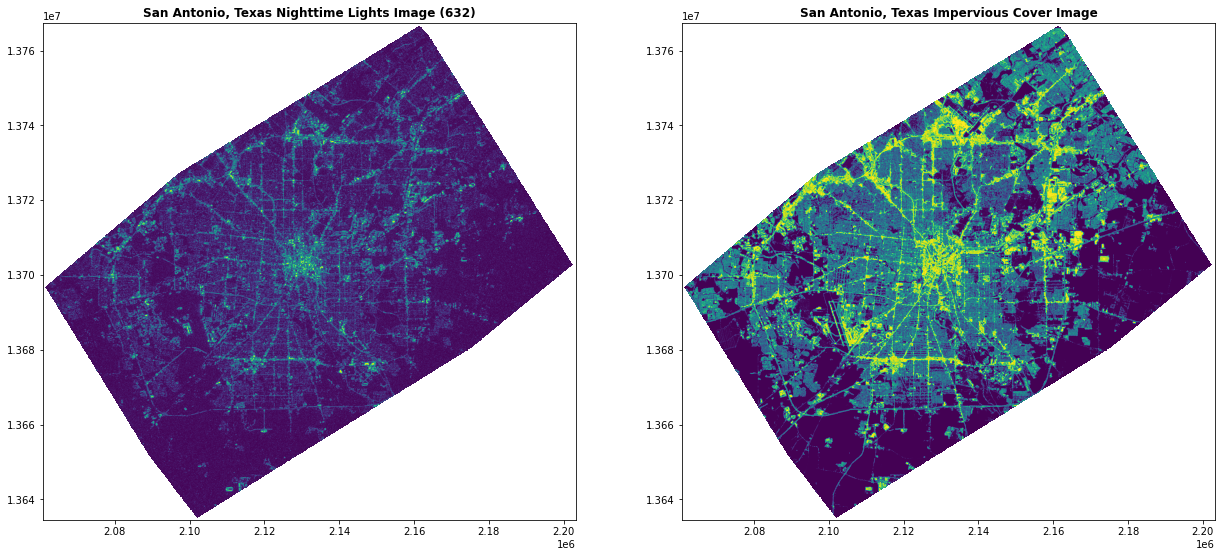

In [35]:
fig, ax = plt.subplots(1,2, figsize=(21,10))
show(ntl, title=f"San Antonio, Texas Nighttime Lights Image ({selected_image})", ax=ax[0])
show(impervious, title="San Antonio, Texas Impervious Cover Image", ax=ax[1])

### Mask the nighttime lights (x), impervious cover (y), and GLCM Texture (t) data and print their metadata

In [124]:
n = ntl.read(1).flatten().astype('float32')
# x = ntl.read(1).flatten().astype('float32')
y = impervious.read(1).flatten().astype('float32')
t = tex.read(1).flatten().astype('float32')
print(f"The original shape of 'n' is {n.shape}", end=" <--> ")
# print(f"The original shape of 'x' is {x.shape}", end=" <--> ")
print(f"The original shape of 'y' is {y.shape}", end=" <--> ")
print(f"The original shape of 't' is {t.shape}")

# Depending on the system where the original data (images) were created
# NoData values may be code as very small (i.e., negative) numbers...or...
# as very large positive numbers. So even though the actual range of
# impervious cover should be [0..255], there will be a large or a small value
# representing NoData values. 500 is larger than the expected largest value,
# but less than the possible NoData value. (I could have replace 500 with 255.)

n = ma.masked_where(n <= 1, n)
n = ma.masked_where(n > 500, n)

# x = ma.masked_where(x <= 1, x)
# x = ma.masked_where(x > 500, x)
y = ma.masked_where(y <= 1, y)
y = ma.masked_where(y >= 100, y)

n = ma.masked_where(y.mask==True, n)
# x = ma.masked_where(y.mask==True, x)
y = ma.masked_where(n.mask==True, y)
# y = ma.masked_where(x.mask==True, y)
t = ma.masked_where(y.mask==True, t)

n = ma.compressed(n)
# x = ma.compressed(x)
y = ma.compressed(y)
t = ma.compressed(t)

print(f"The masked shape of 'n' is {n.shape}", end=" <--> ")
# print(f"The masked shape of 'x' is {x.shape}", end=" <--> ")
print(f"The masked shape of 'y' data is {y.shape}", end=" <--> ")
print(f"The masked shape of 't' data is {t.shape}")
print()
print(f"The min/max values for 'x' (nighttime lights) are {x.min()} and {x.max()}, respectively.")
print()
print(f"The min/max values for 'y' (impervious cover) are {y.min()} and {y.max()}, respectively.")
print()
print(f"The min/max values for 't' (GLCM texture) are {np.nanmin(t)} and {np.nanmax(t)}, respectively.")

The original shape of 'n' is (1953450,) <--> The original shape of 'y' is (1953450,) <--> The original shape of 't' is (1953450,)
The masked shape of 'n' is (633145,) <--> The masked shape of 'y' data is (633145,) <--> The masked shape of 't' data is (633145,)

The min/max values for 'x' (nighttime lights) are 2.0 and 255.0, respectively.

The min/max values for 'y' (impervious cover) are 2.0 and 99.0, respectively.

The min/max values for 't' (GLCM texture) are 20.46286964416504 and 27219.861328125, respectively.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
57.07601
nan
86.21712
85.49603
81.55244
nan
nan
119.72336
124.10884
123.54507
121.05414
nan
180.8665
190.28827
188.14342
235.4263
236.37556
233.0275
nan
nan
nan
nan
153.82991
152.86517
245.65987
262.82993
280.54648
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
140.79341
140.87193
153.30022
155.47833
165.04393
182.35374
196.62358
218.6712
234.24944
263.9161
287.59637
307.3719
309.14966
304.84354
280.8788
260.404

## Combine GLCM Texture and Intensity images to produce a modified texture image

In [110]:
# 1. Reclassify GLCM Texture image at min/max values: t = f(t)
# 2. Divide by the new max value (to produce values between 0 and 1): t = f(t)
# 3. Multiply original NTL image by the rescaled values (from #2): x = f(t * n)

# x = n
# print(x.dtype)
# print(x.shape)

### Create logx as log(x) and print some metadata

In [111]:
logx = np.log(x)
print(f"The masked shape of 'logx' is {logx.shape}")
print()
print(f"The min/max values for 'logx' (nighttime lights) are {logx.min()} and {logx.max()}, respectively.")
print(logx)

The masked shape of 'logx' is (633145,)

The min/max values for 'logx' (nighttime lights) are 0.6931471824645996 and 5.541263580322266, respectively.
[1.9459102 2.3978953 3.295837  ... 3.2580965 3.1354942 1.609438 ]


### Plot histograms of x, logx, y, and logy (using matplotlib)

Text(0.5, 0, 'Log GLCM Texture')

<Figure size 432x288 with 0 Axes>

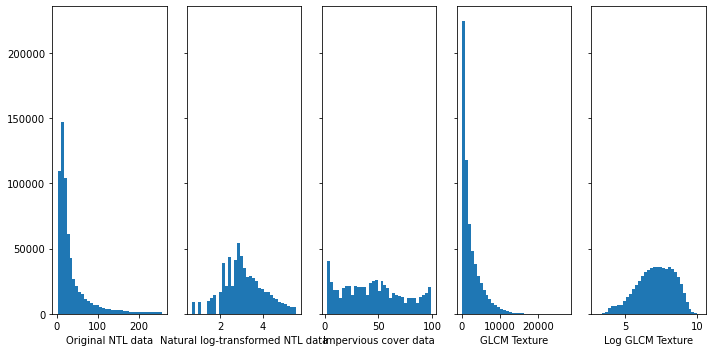

In [112]:
bins = 35
plt.clf()
fig, axs = plt.subplots(1, 5, sharey=True, tight_layout=True, figsize=(10, 5))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=bins)
axs[0].set_xlabel("Original NTL data")
axs[1].hist(logx, bins=bins)
axs[1].set_xlabel("Natural log-transformed NTL data")
axs[2].hist(y, bins=bins)
axs[2].set_xlabel("Impervious cover data")
axs[3].hist(t, bins=bins)
axs[3].set_xlabel("GLCM Texture")
axs[4].hist(np.log(t), bins=bins)
axs[4].set_xlabel("Log GLCM Texture")

### Plot heatmaps

<ipython-input-113-4b7abb438c37>:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  c0 = axs[0].imshow(heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=extent, origin='lower', aspect='auto')
<ipython-input-113-4b7abb438c37>:18: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  c1 = axs[1].imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')


<Figure size 432x288 with 0 Axes>

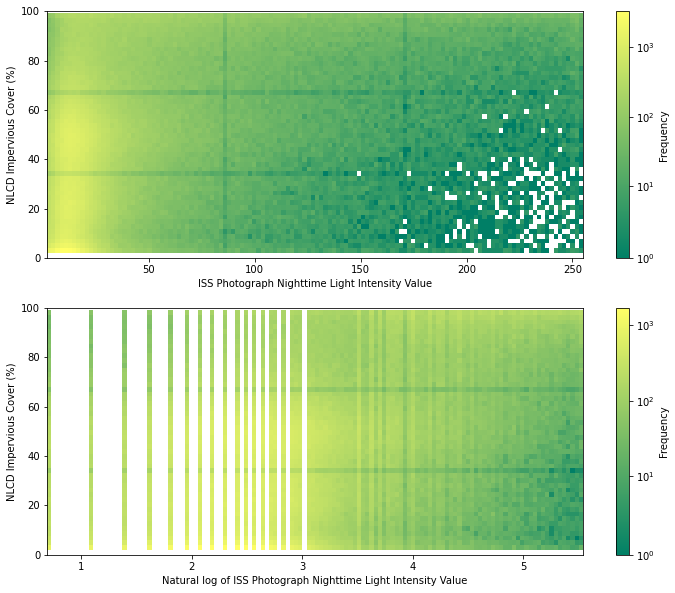

In [113]:
# Original NTL heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(128, 50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap[heatmap == 0] = np.NaN

# Log transformed NTL heatmap
log_heatmap, log_xedges, log_yedges = np.histogram2d(logx, y, bins=(128, 50))
log_extent = [log_xedges[0], log_xedges[-1], log_yedges[0], log_yedges[-1]]
log_heatmap[log_heatmap == 0] = np.NaN

# Setup sub-plots
plt.clf()
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(12, 10))
fig.subplots_adjust(hspace=0.2)

# Plot heatmaps
c0 = axs[0].imshow(heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=extent, origin='lower', aspect='auto')
c1 = axs[1].imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')

# Add plot labels
axs[0].set_ylim([0, 100])
axs[0].set_xlabel("ISS Photograph Nighttime Light Intensity Value")
axs[0].set_ylabel("NLCD Impervious Cover (%)")
cbar0 = fig.colorbar(c0, ax=axs[0], ticks=[1, 10, 100, 1000, 10000, 100000])
cbar0.ax.set_ylabel('Frequency')

axs[1].set_ylim([0, 100])
axs[1].set_xlabel("Natural log of ISS Photograph Nighttime Light Intensity Value")
axs[1].set_ylabel("NLCD Impervious Cover (%)")
cbar1 = fig.colorbar(c1, ax=axs[1], ticks=[1, 10, 100, 1000, 10000])
cbar1.ax.set_ylabel('Frequency')

plt.show()

## OLS Regression

In [96]:
# Set 'regress_through_origin' to True if regression through origin is desired
regress_through_origin = True
if regress_through_origin:
    X = x
else:
    X = sm.add_constant(x, prepend=False)

ols_mod = sm.OLS(y, X)
ols_results = ols_mod.fit()
print(ols_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.494
Model:                            OLS   Adj. R-squared (uncentered):              0.494
Method:                 Least Squares   F-statistic:                          6.180e+05
Date:                Tue, 18 May 2021   Prob (F-statistic):                        0.00
Time:                        21:04:02   Log-Likelihood:                     -3.1978e+06
No. Observations:              633145   AIC:                                  6.396e+06
Df Residuals:                  633144   BIC:                                  6.396e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## OLS Regression with log(ISS)

In [97]:
# Set 'regress_through_origin' to True if regression through origin is desired
regress_through_origin = True
if regress_through_origin:
    logX = logx
else:
    logX = sm.add_constant(logx, prepend=False)

log_mod = sm.OLS(y, logX)
log_results = log_mod.fit()
print(log_results.params)
print(log_results.summary())

[14.301458]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.763
Model:                            OLS   Adj. R-squared (uncentered):              0.763
Method:                 Least Squares   F-statistic:                          2.042e+06
Date:                Tue, 18 May 2021   Prob (F-statistic):                        0.00
Time:                        21:04:02   Log-Likelihood:                     -2.9572e+06
No. Observations:              633145   AIC:                                  5.914e+06
Df Residuals:                  633144   BIC:                                  5.914e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [98]:
ci = log_results.conf_int(alpha=0.025, cols=None)
print(ci)

[[14.279027 14.32389 ]]


## Feature Space Image generation

### Plot feature space image with regression lines

<ipython-input-99-362310326f2f>:12: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  c1 = axs.imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')


<Figure size 432x288 with 0 Axes>

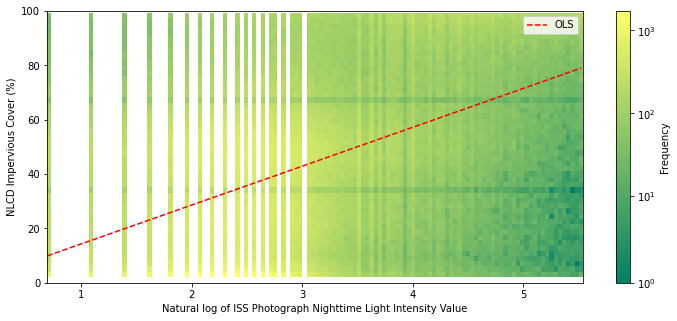

In [99]:
# Log transformed NTL heatmap
log_heatmap, log_xedges, log_yedges = np.histogram2d(logx, y, bins=(128, 50))
log_extent = [log_xedges[0], log_xedges[-1], log_yedges[0], log_yedges[-1]]
log_heatmap[log_heatmap == 0] = np.NaN

# Setup sub-plots
plt.clf()
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12, 5))
# fig.subplots_adjust(hspace=0.2)

# Plot heatmaps
c1 = axs.imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')

# Add plot labels for heatmaps
axs.set_ylim([0, 100])
axs.set_xlabel("Natural log of ISS Photograph Nighttime Light Intensity Value")
axs.set_ylabel("NLCD Impervious Cover (%)")
cbar1 = fig.colorbar(c1, ax=axs, ticks=[1, 10, 100, 1000, 10000, 100000])
cbar1.ax.set_ylabel('Frequency')

# Plot regression lines
get_every_nth = 999

## Log transformed x values
    ### OLS
df_log_ols = pd.DataFrame(columns=['y', 'x'])
df_log_ols['x'] = logx
df_log_ols['y'] = log_results.fittedvalues
df_log_ols = df_log_ols.sort_values(by=['x']).reset_index(drop=True)
df_log_ols = df_log_ols[df_log_ols.index % get_every_nth == 0]
axs.plot(df_log_ols['x'], df_log_ols['y'], 'r--', label="OLS")

axs.legend(loc='best')

plt.show()

In [66]:
a = np.array([[1, 1, 1],[1, 1, 1]])
a

array([[1, 1, 1],
       [1, 1, 1]])

In [67]:
b = np.array([[5, 5, 5],[5, 5, 5]])
b

array([[5, 5, 5],
       [5, 5, 5]])

In [68]:
a - b

array([[-4, -4, -4],
       [-4, -4, -4]])